In [33]:
import numpy as np 
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import random
from PIL import Image
from sklearn.model_selection import train_test_split

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [2]:
# constants and hyperparameters
TEST_PERC = 0.1
BATCH_SIZE = 32
NUM_EPOCHS = 10
DROPOUT_RATE = 0.2
LR = 0.001
BETA1 = 0.9
BETA2 = 0.999
EPSILON = 1.0e-8
DECAY = 0.0
VAL_PERC = 0.1

In [3]:
def generate_random_index_list(index_range, list_size):
    random.seed()
    index_list = []
    while(len(index_list)<list_size):
        index = random.randint(0,index_range)
        if((index in index_list)==False):
            index_list.append(index)
    return index_list         


In [4]:
if(os.path.isdir(os.getcwd()+'/dataset/processed') == False):
    species = pd.read_csv('class_names.csv').values.tolist()
    species.insert(0,['Alfafa'])
    i = 0
    os.makedirs(os.getcwd()+'/dataset/processed', exist_ok=True)
    os.makedirs(os.getcwd()+'/dataset/processed/training', exist_ok=True)
    os.makedirs(os.getcwd()+'/dataset/processed/testing', exist_ok=True)
    
    for dirname, _, filenames in os.walk(os.getcwd()+'/dataset/resized'):
        cur_specie = species[i][0]
        train_class_dir = os.getcwd()+'/dataset/processed/training/'+cur_specie
        test_class_dir = os.getcwd()+'/dataset/processed/testing/'+cur_specie
        os.makedirs(train_class_dir, exist_ok=True)
        os.makedirs(test_class_dir, exist_ok=True)
        
        rand_indices = generate_random_index_list(len(filenames),int(len(filenames)*TEST_PERC))
        
        img_count = 1
        for filename in filenames:
            image = Image.open(os.path.join(dirname, filename))
            img_width, img_height = image.size
            if(img_width == img_height):
                image = image.resize((256,256))
            elif(img_width > img_height):
                image = image.resize((img_width, 256)).crop((0,0,256,256))
            else:
                image = image.resize((256, img_height)).crop((0,0,256,256))
            if(img_count in rand_indices):
                image.save(test_class_dir+'/'+cur_specie+str(img_count)+'.png')
            else:
                image.save(train_class_dir+'/'+cur_specie+str(img_count)+'.png')
            img_count += 1
        if(dirname != os.getcwd()+'/dataset/resized'):
            i += 1

In [5]:
def loadDataset(path):
    data = []
    for dirname, _, filenames in os.walk(path):
        for filename in filenames:
            image = Image.open(os.path.join(dirname, filename))
            data.append([pd.array(image.getdata()),dirname])
    return pd.DataFrame(data)
            
    

In [6]:
from tensorflow.keras.preprocessing import image_dataset_from_directory
train_dataset = image_dataset_from_directory(os.getcwd()+'/dataset/processed/training',
                                             validation_split = VAL_PERC,
                                             subset = "training",
                                             seed = 123,
                                             batch_size = BATCH_SIZE)
val_dataset = image_dataset_from_directory(os.getcwd()+'/dataset/processed/training', 
                                             validation_split = VAL_PERC,
                                             subset = "validation",
                                             seed = 123,
                                             batch_size = BATCH_SIZE)

Found 14889 files belonging to 35 classes.
Using 13401 files for training.
Found 14889 files belonging to 35 classes.
Using 1488 files for validation.


In [7]:
test_dataset = image_dataset_from_directory(os.getcwd()+'/dataset/processed/testing',
                                            batch_size=BATCH_SIZE)

Found 1637 files belonging to 35 classes.


In [8]:
class_names = train_dataset.class_names
test_class_names = test_dataset.class_names
print(class_names==test_class_names)

True


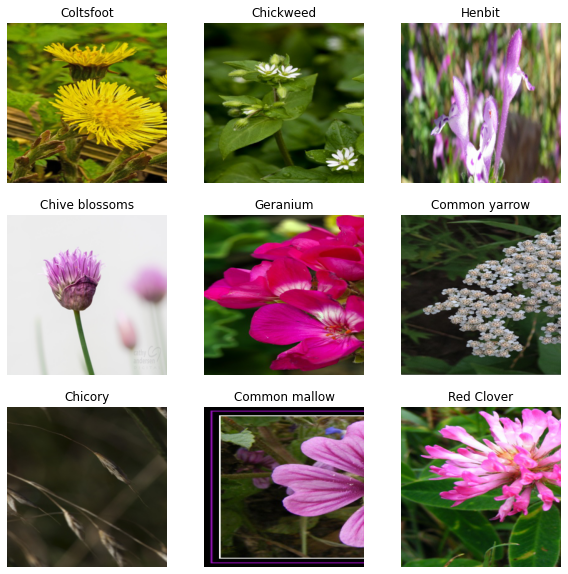

In [72]:
plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [208]:
for image_batch, labels_batch in train_dataset:
    print(image_batch.numpy())
    print(labels_batch.numpy())
    break

[[[[ 99. 111.  75.]
   [103. 115.  79.]
   [102. 114.  76.]
   ...
   [109. 115.  98.]
   [139. 130.  98.]
   [115.  98.  58.]]

  [[ 91. 101.  74.]
   [ 97. 108.  78.]
   [ 99. 111.  81.]
   ...
   [107. 112. 104.]
   [138. 130. 105.]
   [106.  91.  60.]]

  [[ 79.  88.  71.]
   [ 75.  85.  68.]
   [ 79.  90.  74.]
   ...
   [101. 104.  99.]
   [122. 114.  93.]
   [ 98.  86.  62.]]

  ...

  [[ 67.  68.  62.]
   [ 72.  73.  67.]
   [ 62.  63.  58.]
   ...
   [ 94. 110.  56.]
   [103. 117.  56.]
   [ 87.  99.  48.]]

  [[ 69.  70.  64.]
   [ 75.  76.  70.]
   [ 65.  67.  62.]
   ...
   [ 86. 101.  54.]
   [ 91. 104.  52.]
   [ 78.  89.  49.]]

  [[ 70.  71.  65.]
   [ 77.  78.  71.]
   [ 67.  69.  63.]
   ...
   [ 79.  93.  53.]
   [ 80.  91.  48.]
   [ 71.  81.  47.]]]


 [[[ 81.  90.  33.]
   [ 80.  89.  32.]
   [ 81.  89.  32.]
   ...
   [  8.  14.   4.]
   [  7.  12.   5.]
   [  7.  12.   5.]]

  [[ 81.  89.  32.]
   [ 81.  89.  32.]
   [ 81.  89.  32.]
   ...
   [ 11.  15.   6.]
 

In [9]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_dataset.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_dataset.cache().prefetch(buffer_size=AUTOTUNE)

In [10]:
normalization_layer = layers.Rescaling(1./255)

In [11]:
model_name = 'model_cnn'

history_file = os.path.join(model_name, f'history_{model_name}.csv')
logdir = os.path.join(model_name, 'log')
ckpts = os.path.join(model_name, 'ckpts')
os.makedirs(logdir, exist_ok=True)
os.makedirs(ckpts, exist_ok=True)

In [13]:
normalized_train_dataset = train_dataset.map(lambda x, y: (normalization_layer(x), y))
normalized_val_dataset = val_dataset.map(lambda x,y: (normalization_layer(x),y))
image_batch, labels_batch = next(iter(normalized_train_dataset))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 0.9843138


In [14]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",input_shape=(256,256,3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

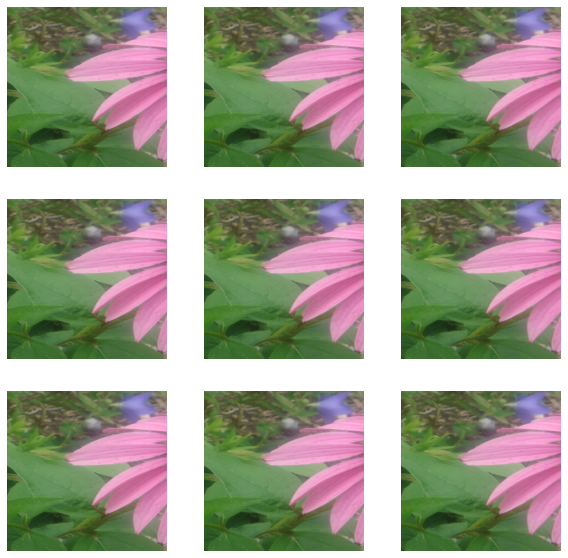

In [188]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

In [23]:
# build model
num_classes = len(class_names)

model = Sequential([
    layers.Rescaling(1./255, input_shape=(256, 256, 3)),
  
    layers.Conv2D(8, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
      
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    
    layers.Conv2D(128, 3, padding='same', activation='relu'),
    layers.MaxPool2D(),
    
    layers.Conv2D(256, 3, padding='same', activation='relu'),
    layers.MaxPool2D(),
    
    layers.Conv2D(512, 3, padding='same', activation='relu'),
    layers.MaxPool2D(),
    
    layers.Flatten(),
    layers.Dense(2*num_classes, activation='relu'),
    layers.Dense(num_classes)
])

In [24]:
from tensorflow.keras import optimizers, losses, metrics
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard

# set optimizer
opt = optimizers.Adam(learning_rate=LR,
    beta_1=BETA1,
    beta_2=BETA2,
    epsilon=EPSILON,
    decay=DECAY)

In [25]:
# set loss and metrics
loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
metrics=['accuracy']

In [26]:
# compile model: optimization method, training criterion and metrics
model.compile(
  optimizer=opt,
  loss=loss,
  metrics=metrics
)
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_2 (Rescaling)     (None, 256, 256, 3)       0         
                                                                 
 conv2d_8 (Conv2D)           (None, 256, 256, 8)       224       
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 128, 128, 8)      0         
 2D)                                                             
                                                                 
 conv2d_9 (Conv2D)           (None, 128, 128, 16)      1168      
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 64, 64, 16)       0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 64, 64, 32)       

In [27]:
# process input arguments
#parser = argparse.ArgumentParser()
#parser.add_argument('--model_name', 
#                    type=str,
#                    default='model_lstm', 
#                    help='--model_name=<model1|model2|...>')
#args = vars(parser.parse_args())
model_name	= 'model_cnn'

#print(f'\nModel type: {model_name}')

history_file = os.path.join(model_name, f'history_{model_name}.csv')
logdir = os.path.join(model_name, 'log')
ckpts = os.path.join(model_name, 'ckpts')
os.makedirs(logdir, exist_ok=True)
os.makedirs(ckpts, exist_ok=True)

In [28]:
# early stop, save best checkpoint
filepath = ckpts + '/weights-improvement-{epoch:02d}-{val_accuracy:.4f}.hdf5'
callbacks_list = [
  EarlyStopping(
    monitor='accuracy',
    patience=10),
  ModelCheckpoint(
    filepath=filepath,
    monitor='val_accuracy',
    save_best_only=True,
    verbose=1),
  TensorBoard(
    log_dir=logdir),
    ]

In [29]:
# train model
history = model.fit(train_dataset,
  epochs=NUM_EPOCHS,
  batch_size=BATCH_SIZE,
  validation_data=val_dataset,
  callbacks=callbacks_list,
  verbose=1)

Epoch 1/10
418/419 [============================>.] - ETA: 0s - loss: 3.3452 - accuracy: 0.0655
Epoch 1: val_accuracy improved from -inf to 0.12567, saving model to model_cnn\ckpts\weights-improvement-01-0.1257.hdf5
419/419 [==============================] - 33s 75ms/step - loss: 3.3447 - accuracy: 0.0654 - val_loss: 3.0894 - val_accuracy: 0.1257
Epoch 2/10
418/419 [============================>.] - ETA: 0s - loss: 2.8483 - accuracy: 0.1823
Epoch 2: val_accuracy improved from 0.12567 to 0.22917, saving model to model_cnn\ckpts\weights-improvement-02-0.2292.hdf5
419/419 [==============================] - 30s 72ms/step - loss: 2.8477 - accuracy: 0.1823 - val_loss: 2.7236 - val_accuracy: 0.2292
Epoch 3/10
418/419 [============================>.] - ETA: 0s - loss: 2.2825 - accuracy: 0.3206
Epoch 3: val_accuracy improved from 0.22917 to 0.32863, saving model to model_cnn\ckpts\weights-improvement-03-0.3286.hdf5
419/419 [==============================] - 31s 74ms/step - loss: 2.2827 - accura

In [30]:
# train model
history = model.fit(train_dataset,
  epochs=NUM_EPOCHS,
  batch_size=BATCH_SIZE,
  validation_data=val_dataset,
  callbacks=callbacks_list,
  verbose=1)

Epoch 1/10
418/419 [============================>.] - ETA: 0s - loss: 0.5311 - accuracy: 0.8363
Epoch 1: val_accuracy did not improve from 0.54099
419/419 [==============================] - 32s 75ms/step - loss: 0.5306 - accuracy: 0.8364 - val_loss: 2.3870 - val_accuracy: 0.5282
Epoch 2/10
418/419 [============================>.] - ETA: 0s - loss: 0.4248 - accuracy: 0.8669
Epoch 2: val_accuracy did not improve from 0.54099
419/419 [==============================] - 30s 71ms/step - loss: 0.4244 - accuracy: 0.8670 - val_loss: 2.6800 - val_accuracy: 0.5148
Epoch 3/10
418/419 [============================>.] - ETA: 0s - loss: 0.3410 - accuracy: 0.8954
Epoch 3: val_accuracy did not improve from 0.54099
419/419 [==============================] - 30s 72ms/step - loss: 0.3416 - accuracy: 0.8954 - val_loss: 2.9974 - val_accuracy: 0.5175
Epoch 4/10
418/419 [============================>.] - ETA: 0s - loss: 0.3207 - accuracy: 0.8997
Epoch 4: val_accuracy did not improve from 0.54099
419/419 [====

In [31]:
print(history.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


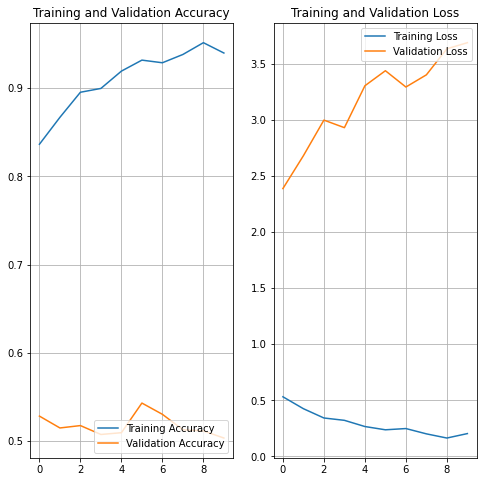

In [34]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(NUM_EPOCHS)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.grid(True)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.grid(True)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [35]:
history_df = pd.DataFrame(history.history)
with open(history_file, mode='w') as f:
	history_df.to_csv(f)
    

In [36]:
model.save(os.path.join(model_name))

INFO:tensorflow:Assets written to: model_cnn\assets


INFO:tensorflow:Assets written to: model_cnn\assets


In [37]:
evaluation_history = model.evaluate(test_dataset)

52/52 [==============================] - 29s 459ms/step - loss: 3.7740 - accuracy: 0.5070


In [38]:
print(evaluation_history)

[3.7739830017089844, 0.5070250630378723]


In [65]:
'''img_path = os.getcwd()+'/dataset/processed/testing/Chicory/Chicory254.png'
img = tf.keras.utils.load_img(img_path)

img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch'''

confusion_matrix = np.zeros((num_classes,num_classes),dtype=int)
i = 0
for dirname, _, filenames in os.walk(os.getcwd()+'/dataset/processed/testing/'):
    for filename in filenames:
        img = tf.keras.utils.load_img(os.path.join(dirname,filename))
        img_array = tf.keras.utils.img_to_array(img)
        img_array = tf.expand_dims(img_array, 0) # Create a batch
        predictions = model.predict(img_array, verbose=0)
        score = tf.nn.softmax(predictions[0])
        confusion_matrix[i][np.argmax(score)]+=1
    if(dirname != os.getcwd()+'/dataset/processed/testing/'):
        i += 1

print(confusion_matrix)

'''print(type(test_dataset))

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)'''

[[ 8  2  1 ... 10  0  2]
 [ 5 17  0 ...  2  1  3]
 [ 1  1 14 ...  6  0  0]
 ...
 [ 2  0  0 ... 32  1  0]
 [ 1  0  0 ...  1 17  0]
 [ 4  1  0 ...  0  0 19]]


'print(type(test_dataset))\n\npredictions = model.predict(img_array)\nscore = tf.nn.softmax(predictions[0])\n\nprint(\n    "This image most likely belongs to {} with a {:.2f} percent confidence."\n    .format(class_names[np.argmax(score)], 100 * np.max(score))\n)'

In [67]:
np.savetxt(os.getcwd()+'/'+model_name+'/confusion_matrix.csv', confusion_matrix, delimiter=',')